In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [14]:
# results_path = "../logs/mbrl_results/results_mujoco_walker2d_medium-v0/results_20250824_110940.parquet"
results_path = "../logs/mbrl_results/results_mujoco_halfcheetah_medium-v0/results_20250824_114531.parquet"
results_df = pd.read_parquet(results_path)

In [15]:
results_df.head()

,epoch,mean_error,loss,grad_norm,hidden_sizes,fixed_logstd,learning_rate,n_updates,loss_type,input_dim,...,NLL,sigma_error,entropy,reward_mean,n_generations,use_rsample,reward_transform,entropy_weight,reward_fn,U
0,0,7.102765,50.449272,16.590466,"[64, 64]",False,0.001,100,MSE,23,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None
1,1,7.062459,49.878334,16.356838,"[64, 64]",False,0.001,100,MSE,23,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None
2,2,7.022490,49.315357,16.192301,"[64, 64]",False,0.001,100,MSE,23,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None
3,3,6.982824,48.759838,16.066206,"[64, 64]",False,0.001,100,MSE,23,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None
4,4,6.943349,48.210091,16.000479,"[64, 64]",False,0.001,100,MSE,23,...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None


ValueError: Axis limits cannot be NaN or Inf

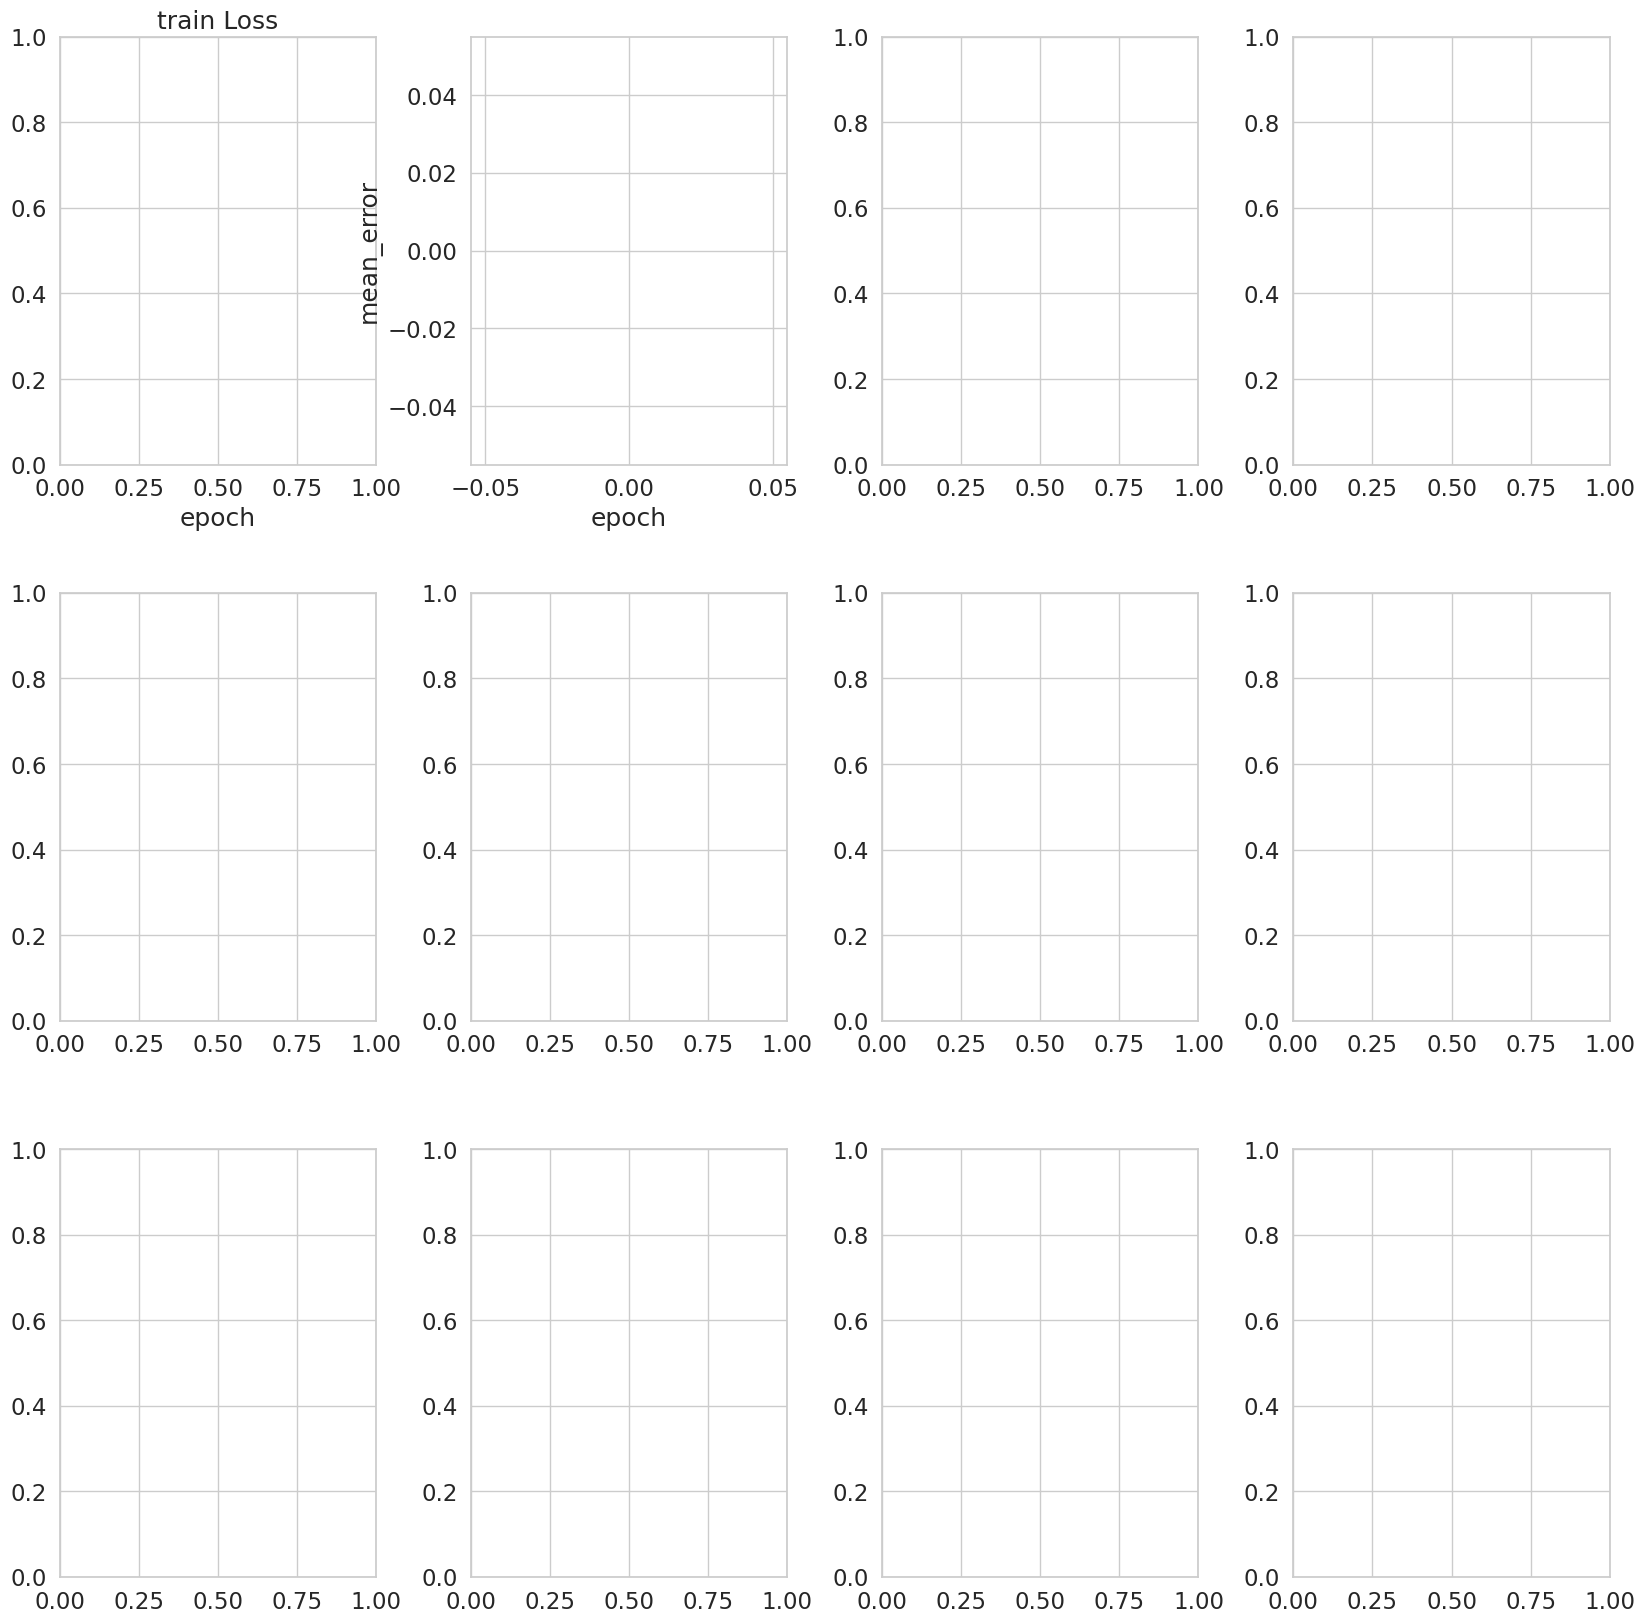

In [16]:
df = results_df[results_df["data_proportion"] == 0.1].copy()
df["entropy_weight"] = df["entropy_weight"].astype("str")

metric_name = []
metric_name.append(("loss", "Loss"))
# metric_name.append(("mean_error", r"$\|\mu-\hat{\mu}_\theta\|^2$"))
metric_name.append(("mean_error", "MSE"))
# metric_name.append(("NLL", r"$\mathbb{E}_q[log\hat{p}_\theta(y|x)]$"))
metric_name.append(("NLL", "NLL"))
# metric_name.append(("std_error", r"$\|\sigma-\hat{\sigma}_\theta\|^2$"))
metric_name.append(("reward_mean", "Reward"))
# metric_name.append(("grad_norm", "Gradient norm"))

_, ax = plt.subplots(
    3, len(metric_name), figsize=(20, 20), gridspec_kw=dict(hspace=0.3, wspace=0.3)
)

# Train / Val
for tr_val_idx, train_val in enumerate(["train", "val"]):
    sub_df = df[df["train_val"] == train_val].copy()
    for i, (metric, name) in enumerate(metric_name):
        sns.lineplot(
            data=sub_df.dropna(subset=["U"]),
            x="epoch",
            y=metric,
            hue="U",  # "entropy_weight",
            # style="U",
            ax=ax[tr_val_idx, i],
            legend=False,
        )
        if metric == "mean_error":
            sns.lineplot(
                data=sub_df[sub_df["loss_type"] == "MSE"],
                x="epoch",
                y=metric,
                ax=ax[tr_val_idx, i],
                color="black",
                legend=False,
            )
        if metric not in ["reward_mean", "loss"]:
            sns.lineplot(
                data=sub_df[sub_df["loss_type"] == "NLL"],
                x="epoch",
                y=metric,
                ax=ax[tr_val_idx, i],
                color="red",
                legend=False,
            )
            max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
            ax[tr_val_idx, i].set_ylim(
                min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
                max_for_lim + 0.1 * max_for_lim,
            )
        ax[tr_val_idx, i].set_ylabel(None)
        ax[tr_val_idx, i].set_title(f"{train_val} {name}")
        ax[tr_val_idx, i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))

# Test
sub_df = df[df["train_val"] == "test"].copy()
for i, (metric, name) in enumerate(metric_name):
    if metric in ["loss", "reward_mean"]:
        continue
    sns.boxplot(
        data=sub_df.dropna(subset=["U"]),
        x="U",
        y=metric,
        hue="U",  # "entropy_weight",
        # style="U",
        ax=ax[2, i],
        legend=False if i != 1 else True,
    )
    if metric == "mean_error":
        sns.boxplot(
            data=sub_df[sub_df["loss_type"] == "MSE"],
            x="loss_type",
            y=metric,
            ax=ax[2, i],
            color="black",
            label="MSE",
        )
    sns.boxplot(
        data=sub_df[sub_df["loss_type"] == "NLL"],
        x="loss_type",
        y=metric,
        ax=ax[2, i],
        color="red",
        label=None if i != 1 else "NLL",
    )
    # max_for_lim = sub_df[(sub_df["loss_type"] == "NLL")][metric].max()
    # ax[i].set_ylim(
    #     min(sub_df[(sub_df["loss_type"] == "NLL")][metric].min(), 0.0),
    #     max_for_lim + 0.1 * max_for_lim,
    # )
    ax[2, i].set_ylabel(None)
    ax[2, i].set_xlabel(None)
    ax[2, i].set_xticklabels([])
    ax[2, i].set_title(f"Test {name}")
    ax[2, i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))

ax[2, 1].legend(bbox_to_anchor=(1.1, -0.21), loc="lower center", ncol=4, frameon=False)
# ax[0].legend(bbox_to_anchor=(1.73, 1.03))
# plt.savefig("../figures/toy_avg.pdf", bbox_inches="tight")
plt.show()